# Experiment 7: Realtime Query

In [1]:
import os

import cv2
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import pyrqlite.dbapi2 as dbapi2
import struct

from tqdm.notebook import tqdm
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO

from face_alignment import align


In [2]:
# Define preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load face embedding model
model_face_embedding = torch.hub.load('otroshi/edgeface', 'edgeface_s_gamma_05', source='github', pretrained=True)

# Move the model to the GPU if available
model_face_embedding = model_face_embedding.to(device)

# Set model to eval
model_face_embedding.eval()

print(f"Model is loaded on {device}")


Using cache found in /root/.cache/torch/hub/otroshi_edgeface_main


Model is loaded on cuda


In [4]:
# Load YOLO model
model_yolo = YOLO("models/yolov11s-face.pt")


In [5]:
# Connect to the database
connection = dbapi2.connect(
    host='localhost',
    port=4001,
)

# Check SQLite and sqlite-vec version
conn = connection.cursor()
conn.execute("SELECT sqlite_version(), vec_version()")
sqlite_version, vec_version = conn.fetchone()
print(f"SQLite Version: {sqlite_version}, sqlite-vec Version: {vec_version}")


SQLite Version: 3.46.1, sqlite-vec Version: v0.1.6


In [6]:
# Function to serialize embeddings
def serialize_f32(vector):
    """Serialize a list of floats into raw bytes for storage."""
    return struct.pack("%sf" % len(vector), *vector)


In [7]:
# Function to find similar images
def find_similar_images(query_embedding, top_n=5):
    query_vector = serialize_f32(query_embedding)
    rows = conn.execute(
        """
        SELECT rowid, name, file_dir, distance
        FROM images
        WHERE embedding MATCH ?
        AND k = ?
        ORDER BY distance
        """,
        (query_vector, top_n),
    ).fetchall()
    
    return rows

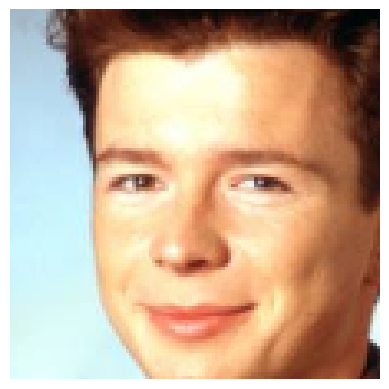

Top similar images:
(139, 'name_186', 'temp_data/186.jpg', 0.28649812936782837)


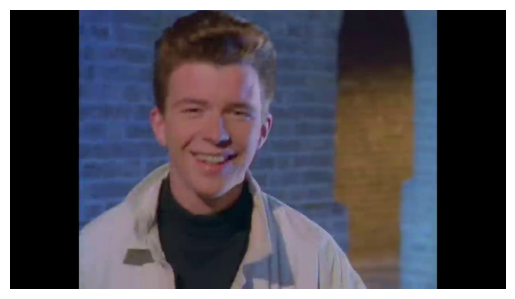

(151, 'name_198', 'temp_data/198.jpg', 0.2883158326148987)


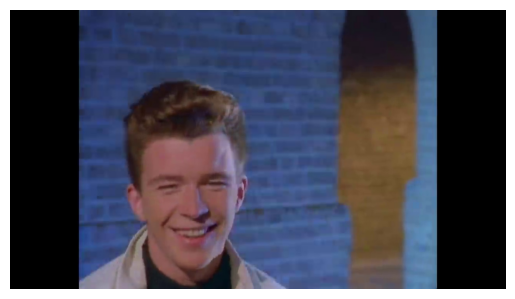

(150, 'name_197', 'temp_data/197.jpg', 0.2900118827819824)


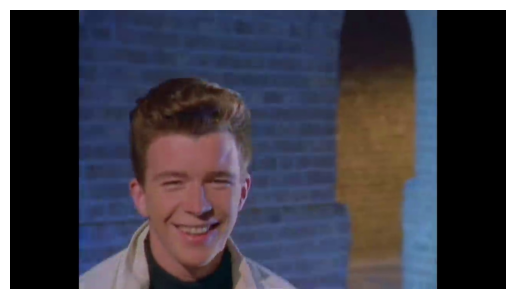

(149, 'name_196', 'temp_data/196.jpg', 0.3011881709098816)


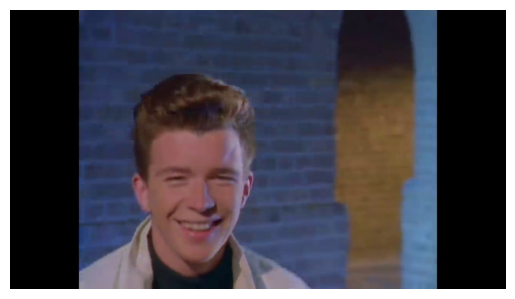

(140, 'name_187', 'temp_data/187.jpg', 0.3039454519748688)


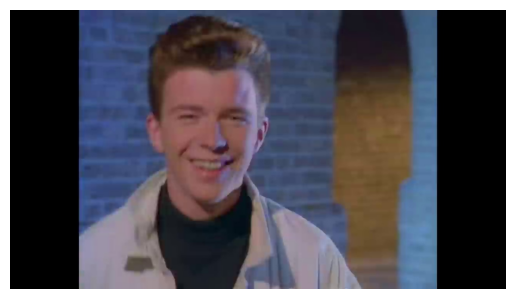

In [17]:
# Example: Query with a specific face embedding (e.g., first embedding in the list)
# query_embedding = embeddings_list[0]  # Let's use the first image's embedding as the query
image_path = "test_images/rick_astley.jpg"
input_image = cv2.imread(image_path)

# Convert the image to RGB
input_image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

pil_image = Image.fromarray(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
aligned = align.get_aligned_face(None, pil_image)  # align face

# Plot the image
plt.imshow(aligned)
plt.axis("off")  # Hide axis
plt.show()

if aligned is not None:
    transformed_input = transform(aligned).unsqueeze(0).to(device)  # preprocessing
    face_embedding = model_face_embedding(transformed_input).cpu().detach().numpy().flatten()


    query_embedding = face_embedding
    query_results = find_similar_images(query_embedding)

    print("Top similar images:")
    for query in query_results:
        print(query)

        image = cv2.imread(query[2])

        # Plot Image
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis("off")  # Hide axis
        plt.show()
else:
    print("invalid alignment")
